## set data

In [1]:
df = pd.read_csv('../data/user_detail.csv')
df = df[['id', 'title', 'score']]

In [2]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder

# 개인정보 보호를 위해 id 인코딩
id_ = LabelEncoder()
df['id'] = id_.fit_transform(df['id'])

In [3]:
df.tail()

,id,title,score
101102,9329,Dusty Raging Fist,10
101103,9329,Sea of Thieves,9
101104,11924,Rogue Aces,9
101105,11924,Star Wars Battlefront II,0
101106,15435,Project Nimbus: Code Mirai,10


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101107 entries, 0 to 101106
Data columns (total 3 columns):
id       101107 non-null int64
title    101107 non-null object
score    101107 non-null int64
dtypes: int64(2), object(1)
memory usage: 2.3+ MB


In [5]:
df.describe()

,id,score
count,101107.000000,101107.000000
mean,8571.260407,6.941339
std,4953.846175,3.125917
min,0.000000,0.000000
25%,4189.500000,5.000000
50%,8723.000000,8.000000
75%,12779.500000,9.000000
max,17263.000000,10.000000


In [6]:
unique_user = df["id"].unique()
print('\n평가한 유저의 수:', len(unique_user))
unique_game = df["title"].unique()
print('평가된 게임의 수:', len(unique_game))


평가한 유저의 수: 17264
평가된 게임의 수: 8811



score count


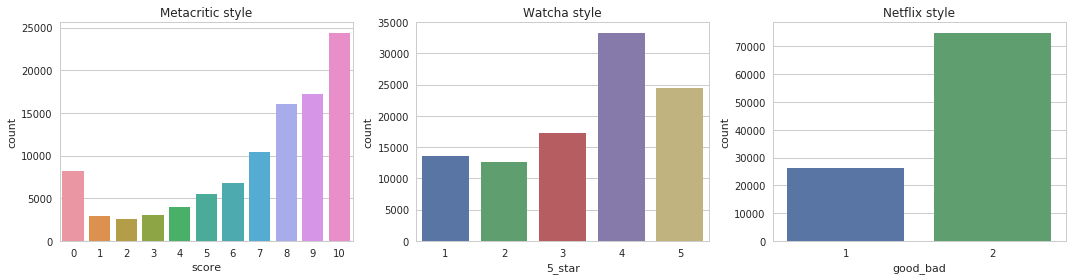

In [7]:
%matplotlib inline
df['5_star'] = df.score.apply(lambda x: 1 if x<3 else 2 if x<6 else 3 if x<8 else 4 if x<10 else 5) # 012/345/67/89/10
df['good_bad'] = df.score.apply(lambda x: 1 if x<6 else 2) #012345/678910
print("\nscore count")
plt.figure(figsize=(15,4))
plt.subplot(131)
plt.title('Metacritic style')
sns.countplot(df.score)
plt.subplot(132)
plt.title('Watcha style')
sns.countplot(df['5_star'])
plt.subplot(133)
plt.title('Netflix style')
sns.countplot(df['good_bad'])
plt.tight_layout()
plt.show()

In [8]:
# user 분포
user_counts_df = df.groupby("id").size().reset_index(name="user_rating_count")
user_counts_df = user_counts_df.sort_values("user_rating_count", ascending=False)
user_counts_df.head()

,id,user_rating_count
9015,9015,980
9416,9416,787
1266,1266,674
3430,3430,569
13129,13129,446


In [9]:
# title 분포
title_counts_df = df.groupby("title").size().reset_index(name="title_rating_count")
title_counts_df = title_counts_df.sort_values("title_rating_count", ascending=False)
title_counts_df.head()

,title,title_rating_count
7808,The Witcher 3: Wild Hunt,824
2545,Fallout 4,804
1776,Destiny,789
3107,Grand Theft Auto V,749
8192,Uncharted 4: A Thief's End,718


---

In [10]:
# user 최소 평가수, title 최소 평가수
user_limit, title_limit = 1, 1

filtered_id = user_counts_df[user_counts_df["user_rating_count"] >= user_limit]
filtered_id = list(filtered_id["id"])

filtered_title = title_counts_df[title_counts_df["title_rating_count"] >= title_limit]
filtered_title = list(filtered_title["title"])

filtered_df = df[df["id"].isin(filtered_id)]
filtered_df = filtered_df[filtered_df["title"].isin(filtered_title)]

print("\n", user_limit, "개 이상 평가한 고객\n", title_limit, "번 이상 평가된 게임으로 필터링\n")
print("필터링된 데이터 수:", len(filtered_df))
print("원본 데이터 수:", len(df))


 1 개 이상 평가한 고객
 1 번 이상 평가된 게임으로 필터링

필터링된 데이터 수: 101107
원본 데이터 수: 101107


### 몇 번 이상 평가된 게임만 추려서 모델링은 한다는 의미는?
그 이하로 평가된 게임은 **추천하지 않겠다**는 의미 (추천시스템의 성능을 위해)

하지만 평가가 적은 게임은 `추천 시스템을 통해서는` **신규 유입**이 없을 것
    - 이런 방식으로 데이터를 추리는 것은 추천 시스템의 의미가 퇴색 
>**추천 시스템**
>
알려지지 않은 작품을 고객에게 추천하여 주류 작품에만 수요가 몰리는 상황을 타개
> 
공급이 한정적이지 않은 디지털 컨텐츠에도 적용이 되는가?
> - 알려지지 않은 작품(비주류)는 라이센스 비용이 상대적으로 저렴
>- 동일 조건하의 비용 절감은 언제나 옳다

In [11]:
filtered_df.tail()

,id,title,score,5_star,good_bad
101102,9329,Dusty Raging Fist,10,5,2
101103,9329,Sea of Thieves,9,4,2
101104,11924,Rogue Aces,9,4,2
101105,11924,Star Wars Battlefront II,0,1,1
101106,15435,Project Nimbus: Code Mirai,10,5,2


---

## Surprise

In [13]:
import os
import surprise
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split

Meta = Dataset.load_from_df(filtered_df[['id', 'title','score']], reader=Reader(rating_scale=(0,10)))
Watcha = Dataset.load_from_df(filtered_df[['id', 'title','5_star']], reader=Reader(rating_scale=(1,5)))
Netflix = Dataset.load_from_df(filtered_df[['id', 'title','good_bad']], reader=Reader(rating_scale=(1,2)))

### SVD

In [14]:
algo = surprise.SVD()
print('Meta style score:')
m_score = cross_validate(algo, Meta, cv=5, verbose=True, n_jobs=-1)
print('\nWatcha style score:')
w_score = cross_validate(algo, Watcha, cv=5, verbose=True, n_jobs=-1)
print('\nNetflix style score:')
n_score = cross_validate(algo, Netflix , cv=5, verbose=True, n_jobs=-1)

Meta style score:
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    2.4823  2.5010  2.4754  2.4848  2.5036  2.4894  0.0110  
MAE (testset)     1.8576  1.8741  1.8514  1.8575  1.8689  1.8619  0.0083  
Fit time          15.37   16.10   15.58   15.00   8.56    14.12   2.81    
Test time         0.71    0.66    0.65    0.59    0.29    0.58    0.15    

Watcha style score:
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0869  1.0690  1.0721  1.0828  1.0823  1.0786  0.0068  
MAE (testset)     0.8603  0.8413  0.8452  0.8558  0.8564  0.8518  0.0073  
Fit time          14.34   15.24   16.21   15.51   9.36    14.13   2.46    
Test time         0.60    1.05    0.64    0.46    0.24    0.60    0.27    

Netflix style score:
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  F

- 당연하게도, 클래스 수가 적을 수록 MAE, RMSE는 작다.

---

In [15]:
trainset=Meta.build_full_trainset()
Meta_model = surprise.SVD().fit(trainset)

trainset=Watcha.build_full_trainset()
Watcha_model = surprise.SVD().fit(trainset)

trainset=Netflix.build_full_trainset()
Netflix_model = surprise.SVD().fit(trainset)

In [16]:
df[df.title=='Middle-earth: Shadow of War'].tail()

,id,title,score,5_star,good_bad
100265,3272,Middle-earth: Shadow of War,0,1,1
100517,6865,Middle-earth: Shadow of War,9,4,2
101026,14627,Middle-earth: Shadow of War,8,4,2
101070,3792,Middle-earth: Shadow of War,0,1,1
101086,11664,Middle-earth: Shadow of War,10,5,2


metacritic style: 5/5

In [17]:
iid = 'Middle-earth: Shadow of War'
pred=Meta_model.predict(3272, iid, r_ui=0, verbose=True)
pred=Meta_model.predict(6865, iid, r_ui=9, verbose=True)
pred=Meta_model.predict(14627, iid, r_ui=8, verbose=True)
pred=Meta_model.predict(3792, iid, r_ui=0, verbose=True)
pred=Meta_model.predict(11664, iid, r_ui=10, verbose=True)

user: 3272       item: Middle-earth: Shadow of War r_ui = 0.00   est = 0.27   {'was_impossible': False}
user: 6865       item: Middle-earth: Shadow of War r_ui = 9.00   est = 8.83   {'was_impossible': False}
user: 14627      item: Middle-earth: Shadow of War r_ui = 8.00   est = 7.96   {'was_impossible': False}
user: 3792       item: Middle-earth: Shadow of War r_ui = 0.00   est = 0.53   {'was_impossible': False}
user: 11664      item: Middle-earth: Shadow of War r_ui = 10.00   est = 9.90   {'was_impossible': False}


Watcha: 1/5

In [18]:
pred=Watcha_model.predict(3272, iid, r_ui=1, verbose=True)
pred=Watcha_model.predict(6865, iid, r_ui=5, verbose=True)
pred=Watcha_model.predict(14627, iid, r_ui=4, verbose=True)
pred=Watcha_model.predict(3792, iid, r_ui=1, verbose=True)
pred=Watcha_model.predict(11664, iid, r_ui=5, verbose=True)

user: 3272       item: Middle-earth: Shadow of War r_ui = 1.00   est = 1.75   {'was_impossible': False}
user: 6865       item: Middle-earth: Shadow of War r_ui = 5.00   est = 3.35   {'was_impossible': False}
user: 14627      item: Middle-earth: Shadow of War r_ui = 4.00   est = 3.62   {'was_impossible': False}
user: 3792       item: Middle-earth: Shadow of War r_ui = 1.00   est = 1.54   {'was_impossible': False}
user: 11664      item: Middle-earth: Shadow of War r_ui = 5.00   est = 3.98   {'was_impossible': False}


Netflix: 4/5

In [19]:
pred=Netflix_model.predict(3272, iid, r_ui=1, verbose=True)
pred=Netflix_model.predict(6865, iid, r_ui=2, verbose=True)
pred=Netflix_model.predict(14627, iid, r_ui=2, verbose=True)
pred=Netflix_model.predict(3792, iid, r_ui=1, verbose=True)
pred=Netflix_model.predict(11664, iid, r_ui=2, verbose=True)

user: 3272       item: Middle-earth: Shadow of War r_ui = 1.00   est = 1.46   {'was_impossible': False}
user: 6865       item: Middle-earth: Shadow of War r_ui = 2.00   est = 1.51   {'was_impossible': False}
user: 14627      item: Middle-earth: Shadow of War r_ui = 2.00   est = 1.61   {'was_impossible': False}
user: 3792       item: Middle-earth: Shadow of War r_ui = 1.00   est = 1.44   {'was_impossible': False}
user: 11664      item: Middle-earth: Shadow of War r_ui = 2.00   est = 1.44   {'was_impossible': False}


분류해야할 클래스의 수가 적을 수록 정확도가 높아지는 것이 정상.

오히려 더 틀리는 이유?
1. 11개 클래스(0-10) 를 5개, 2개로 나누는 기준 미흡
1. 최적화가 되지 않음

### 추천 시스템에 어떤 평가방식(클래스 수)이 적절할까?

- 어차피 문제는 어떤 작품을 추천 하느냐, 마느냐
- 10점, 5점만점으로 해도 결국 일정 수치를 넘어야 추천을 하게 됨 
- 결국 이진 분류 문제와 같다

#### 이진 분류 문제로 푸는 경우의 문제점

- 사용자가 '얼마나' 좋아하는 지에 대한 척도가 없다 
- 따라서 추천의 우선순위가 사라짐

이진 분류 문제로 풀기 위해서는 `점수` 외에 다른 척도가 필요하다. 

### GridSearchCV

In [20]:
param_grid = {'n_epochs': [60, 80, 90], 
                      'n_factors': [50, 100, 200],
                      'lr_all': [0.005, 0.01, 0.02],
                      'reg_all': [0.01, 0.02, 0.04]}
gs = GridSearchCV(surprise.SVD, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=-1)

In [21]:
%time gs.fit(Netflix)

CPU times: user 1min 16s, sys: 7.07 s, total: 1min 23s
Wall time: 1h 48min 5s


In [22]:
print(gs.best_score['mae'])
print(gs.best_params['mae'])

0.26380477374063827
{'n_epochs': 90, 'n_factors': 50, 'lr_all': 0.02, 'reg_all': 0.02}


In [23]:
trainset=Netflix.build_full_trainset()
Netflix_model = surprise.SVD(n_factors=50, n_epochs=90, lr_all=0.02, reg_all=0.02).fit(trainset)

In [24]:
pred=Netflix_model.predict(3272, iid, r_ui=1, verbose=True)
pred=Netflix_model.predict(6865, iid, r_ui=2, verbose=True)
pred=Netflix_model.predict(14627, iid, r_ui=2, verbose=True)
pred=Netflix_model.predict(3792, iid, r_ui=1, verbose=True)
pred=Netflix_model.predict(11664, iid, r_ui=2, verbose=True)

user: 3272       item: Middle-earth: Shadow of War r_ui = 1.00   est = 1.09   {'was_impossible': False}
user: 6865       item: Middle-earth: Shadow of War r_ui = 2.00   est = 1.89   {'was_impossible': False}
user: 14627      item: Middle-earth: Shadow of War r_ui = 2.00   est = 1.92   {'was_impossible': False}
user: 3792       item: Middle-earth: Shadow of War r_ui = 1.00   est = 1.08   {'was_impossible': False}
user: 11664      item: Middle-earth: Shadow of War r_ui = 2.00   est = 1.95   {'was_impossible': False}


최적화 후에는 결과가 양호해졌다.

하지만 점수 기반으로 추천 시스템을 만들 때 이진 문제로는 한계가 있다.

---